# Quickstart

This document shows how enact can be used to create a simple two-step generative
pipeline, in which we first use an LLM to elaborate a simple user prompt and then
generate an image from the result.

Executing this notebook requires two API keys:
* A [replicate API key](https://replicate.com/account/api-tokens), to access the
Kandinsky diffusion model.
* An [OpenAI API key](https://platform.openai.com/account/api-keys), to access
the `gpt3.5-turbo` version of ChatGPT.

These are expected in files `~/openai.key` and `~/replicate.key`
(where `~/` refers to the user home directory, e.g., `/home/USER_NAME/`
on linux or mac or `C:\Users\USER_NAME` on windows.)

Note: The API calls in this notebook can take a while sometimes up to a minute
or more, so be patient.

In [1]:
import common

_ = common.OPENAI_API_KEY.get()
_ = common.REPLICATE_API_KEY.get()

The `common` module defines functions for accessing these APIs:

Hello, I am an AI assistant designed to help with a variety of tasks and answer your questions.


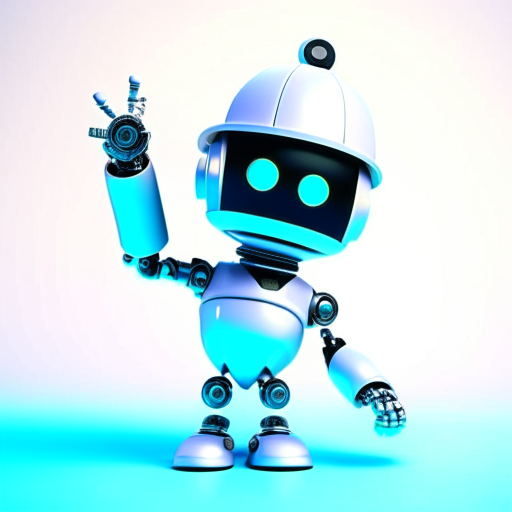

In [2]:
print(common.chat_gpt([('system', 'Briefly introduce yourself')]))
common.kandinsky('A cute robot tipping his top hat in greeting.')

Now let's create the corresponding generative components in enact:

In [3]:
import enact
import dataclasses

@enact.typed_invokable(enact.Str, enact.Str)
@dataclasses.dataclass
class GPTTask(enact.Invokable[enact.Str, enact.Str]):
  task_description: str
  def call(self, task_prompt: enact.Str):
    result = common.chat_gpt([
      ('system', f'TASK DESCRIPTION: {self.task_description}'),
      ('user', task_prompt)])
    return enact.Str(result)

@enact.typed_invokable(enact.Str, enact.Image)
class Kandinsky(enact.Invokable[enact.Str, enact.Image]):
  def call(self, prompt: enact.Str):
    return enact.Image(common.kandinsky(prompt))

... and a pipeline that combines the two:

In [4]:
@enact.typed_invokable(enact.Str, enact.Image)
@dataclasses.dataclass
class Text2Image(enact.Invokable[enact.Str, enact.Image]):
  prompt_refiner: enact.Invokable[enact.Str, enact.Str]
  img_gen: enact.Invokable[enact.Str, enact.Image]

  def call(self, prompt: enact.Str):
    refined_prompt = self.prompt_refiner(prompt)
    return self.img_gen(refined_prompt)
  

prompt_refiner = GPTTask(
'''
You will receive a user prompt that indicates a type of image to create. 
Respond with an elaborated version of the user prompt that is suitable for use
in a text-to-image model.

Adhere closely to these instructions. Only respond with the refined prompt and
say nothing else.
''')

text2image = Text2Image(
  prompt_refiner=prompt_refiner,
  img_gen=Kandinsky())

Let's see this in action. We could simply run `text2image('a cat')`, but we will
_invoke_ `text2image` instead, which creates a journaled execution called an 
`invocation`. This has a few advantages. For one, we'll be able to analyze the
execution to see exactly which prompt led to the creation of the final image.
Additionally, inputs, outputs, invokables and execution details are persisted,
so we can inspect them at a later point, e.g., to find out which task
descriptions work best.

We will use a `FileStore`, which stores all relevant resources in a target
directory.

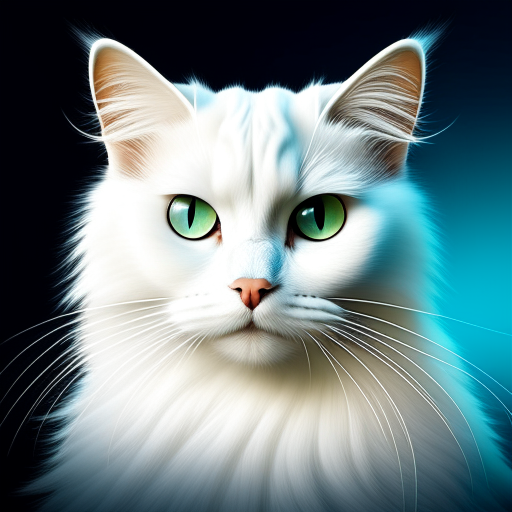

In [5]:
with enact.FileStore('./store_data') as store:
  prompt = enact.commit(enact.Str('a cat'))   # persist the input to disk.
  invocation = text2image.invoke(prompt)      # generate an image.
  output = invocation.get_output()
output.value

Nice, but let's see what kind of prompts our prompt refiner generates. Since the
whole execution is journaled in the invocation object this is pretty easy:

In [6]:
with store:
  # Fetch the first subinvocation, i.e., the first call made into another
  # invokable object.
  prompt_refiner_invocation = invocation.get_child(0)
  # Print the output of the prompt refiner step.
  print(prompt_refiner_invocation.get_output())
  

Create an image of a graceful cat with mesmerizing eyes, silky fur, and a playful yet elegant pose.


It looks like GPT does not understand what a typical prompt looks like and we
need to provide more guidance if we want our cat images to trend on artstation,
so let's append an example to the task description and try again.

refined prompt: stunning digital painting of a graceful cat, with piercing eyes, sleek fur, delicate whiskers, soft lighting, magical atmosphere, realistic texture, created using Procreate app, trending on Instagram and Behance.


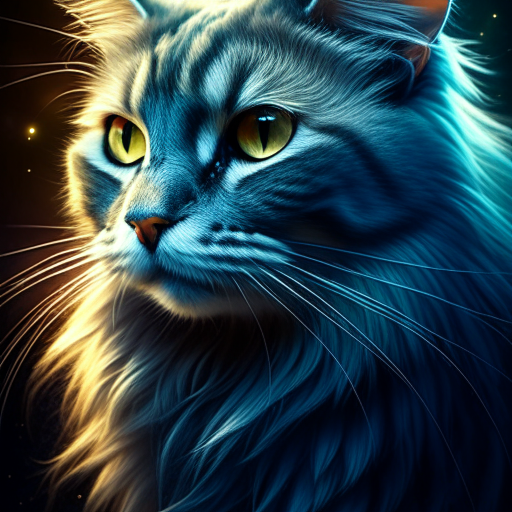

In [7]:
task_example = '''\nFor example, if the user says "dog", you may respond with:
"beautiful illustration of a dog, gorgeous, amazing, flowing hair, muscular, in
the style abigail larsonand and sam guay, rim light, beautiful lighting, 8 k,
stunning scene, octane, trending on artstation".'''

prompt_refiner.task_description += task_example
with store:
  invocation_with_example = text2image.invoke(prompt)
  output = invocation_with_example.get_output()
  print(f'refined prompt: {invocation_with_example.get_child(0).get_output()}')
output.value

Much better...

Invokables can be rewound and replayed, so we can rerun only the second
step of the pipeline - the image generation.

replayed prompt: stunning digital painting of a graceful cat, with piercing eyes, sleek fur, delicate whiskers, soft lighting, magical atmosphere, realistic texture, created using Procreate app, trending on Instagram and Behance.


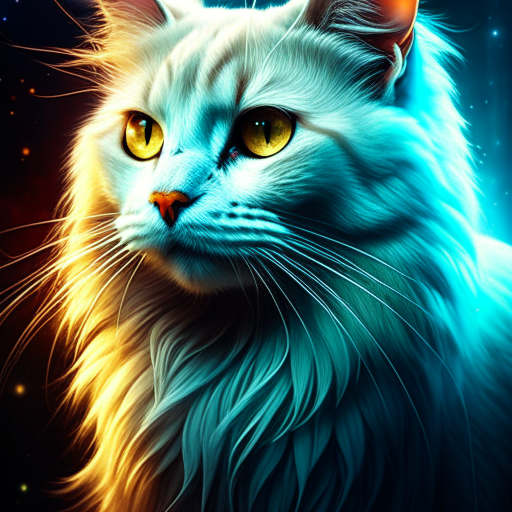

In [8]:
with store:
  # Remove the last call from the invocation, that is, undo image generation.
  rewound_invocation = invocation_with_example.rewind()
  replayed_invocation = rewound_invocation.replay()
  # Confirm that the refined prompt stayed the same
  print(f'replayed prompt: {replayed_invocation.get_child(0).get_output()}')
  output = replayed_invocation.get_output()
output.value
 

Note that we can always revert back to the previous version of the text2image
invokable, since it has been committed along with the first invocation.

In [9]:
# Print details of our original text2image invokable by accessing it through the
# first invocation we generated.
with store:
  enact.pprint(invocation.request().invokable())

Text2Image:
  prompt_refiner: GPTTask(task_description='\nYou will receive a user prompt that indicates a type of image to create. \nRespond with an elaborated version of the user prompt that is suitable for use\nin a text-to-image model.\n\nAdhere closely to these instructions. Only respond with the refined prompt and\nsay nothing else.\n')
  img_gen: Kandinsky()


Once we're happy with our image generation pipeline, we can deploy it, for
example using the enact.gradio integration:

In [10]:
import enact.gradio

with store:
  enact.gradio.GUI(enact.commit(text2image)).launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
